In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch import optim
from sklearn.preprocessing import StandardScaler
from functools import partial
import mlprepare as mlp
import deep_tabular_augmentation as dta
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
os.listdir()

['.ipynb_checkpoints',
 '2021-04-10-DeepLearning_TabularDataAugmentation.ipynb',
 '2_dep.gif',
 'civ6707a-tp2a',
 'DeepLearning_DataAugmentation_RF.ipynb',
 'Enquete_OD_2013_dom108_v3.csv',
 'Enquete_OD_2013_dom108_v3.xlsx',
 'Figures',
 'GAN.ipynb',
 'gen_origines_test.pdf',
 'gen_origines_test.png',
 'Model_fromGPT.ipynb',
 'noise augmentation-all data- final version-Copy1.ipynb',
 'Nouveau dossier',
 'od13_Regdomi8_7_CNORD.csv',
 'single_trip_animation.gif',
 'synthetic_data',
 'synthetic_data.csv',
 'test_données.py',
 'Untitled.ipynb',
 'Untitled1.ipynb',
 '~$Enquete_OD_2013_dom108_v3.xlsx']

# Lecture des données

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

fn = 'Enquete_OD_2013_dom108_v3.csv'

df = pd.read_csv(fn,delimiter=';')
df = df.drop(df[df.D_DESRMR ==0].index)
df = df.drop(df[df.D_ORIRMR ==0].index)

In [29]:
cols = ['P_SEXE','P_GRAGE','D_HREDE','D_ORIXCOOR','D_ORIYCOOR','D_DESTXCOOR','D_DESTYCOOR','D_MODE1']
ncols = len(cols)
df.D_HREDE = (df.D_HREDE//100)+(df.D_HREDE%100)/60
df = df[cols]

Pour utiliser toutes les données: ajouter une colonne uniforme d'utilisation

In [30]:
df = df.assign(use=[1,]*len(df))

Séparer les données en train et test sets: a partir d'ici, le code suit le modèle a https://github.com/siddhi47/deep_tabular_augmentation/blob/main/Notebooks/DeepLearning_DataAugmentation_RF.ipynb

In [31]:
X_train, X_test, y_train, y_test = mlp.split_df(df, dep_var = 'use', test_size=0.3, split_mode='random')

x_scaler = StandardScaler()

X_train_scaled = x_scaler.fit_transform(X_train)

X_test_scaled = x_scaler.transform(X_test)

X_train_use = X_train_scaled[np.where(y_train==1)[0]]
X_test_use = X_test_scaled[np.where(y_test==1)[0]]

In [32]:
datasets = dta.create_datasets(X_train_use, y_train.values[np.where(y_train==1)], X_test_use, y_test.values[np.where(y_test==1)])
data = dta.DataBunch(*dta.create_loaders(datasets, bs=1024, device='cpu'))

Architecture du réseau de neurones:

In [33]:
D_in = X_train_use.shape[1]
VAE_arch = [32, 16, 8]
target_name = 'use'
target_class = 1
df_cols = list(df.columns)

model = dta.Autoencoder(D_in, VAE_arch, latent_dim=5).to(device)
opt = optim.Adam(model.parameters(), lr=0.01)
loss_func = dta.customLoss()

Trouver le learning rate:

In [34]:
learn = dta.Learner(model, opt, loss_func, data, target_name, target_class, df_cols)

run = dta.Runner(cb_funcs=[dta.LR_Find, dta.Recorder])

run.fit(100, learn)

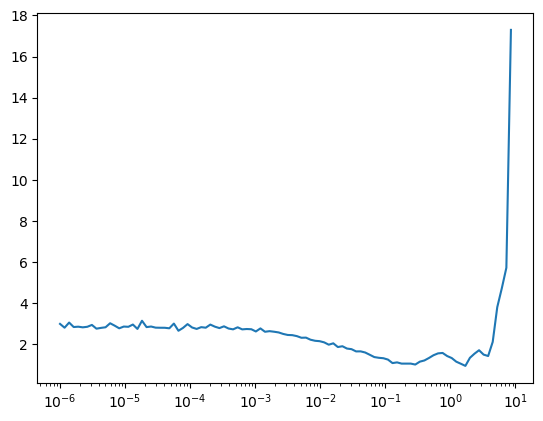

In [10]:
run.recorder.plot(skip_last=0)

In [35]:
sched = dta.combine_scheds([0.3, 0.7], [dta.sched_cos(0.01, 0.1), dta.sched_cos(0.1, 0.01)])

Entrainement du modèle:

In [37]:
cbfs = [partial(dta.LossTracker, show_every=50), dta.Recorder, partial(dta.ParamScheduler, 'lr', sched)]
model = dta.Autoencoder(D_in, VAE_arch, latent_dim=20).to(device)
opt = optim.Adam(model.parameters(), lr=0.001)
learn = dta.Learner(model, opt, loss_func, data, target_name, target_class, df_cols)
run = dta.Runner(cb_funcs=cbfs)
run.fit(200, learn)

epoch: 50
train loss is: 3.025912284851074
validation loss is: 1.144880771636963
epoch: 100
train loss is: 1.099806308746338
validation loss is: 0.9643255472183228
epoch: 150
train loss is: 1.0515187978744507
validation loss is: 0.9612792134284973
epoch: 200
train loss is: 1.0346221923828125
validation loss is: 0.9598307013511658


Let's have a look how train_loss vs val_loss develops:

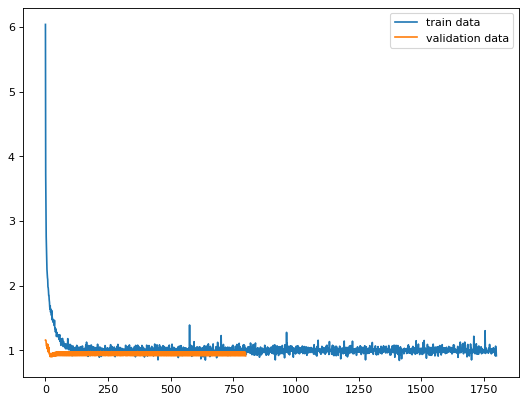

In [38]:
run.loss_tracker.plot_train_vs_val_loss()

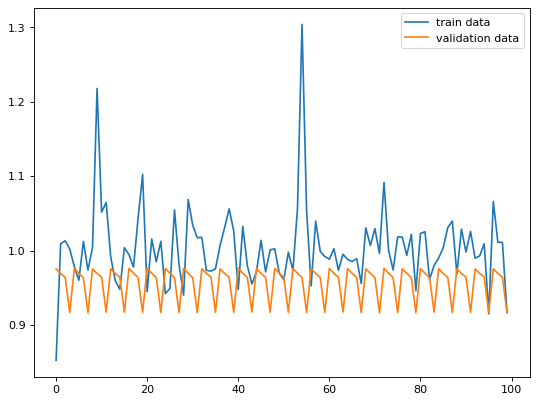

In [39]:
run.loss_tracker.plot_train_vs_val_loss_last_epochs(show_last=100)

Création de données depuis du bruit et examination des statistiques:

In [40]:
difference_in_class_occurences = 1000
df_fake = run.predict_df(learn, no_samples=difference_in_class_occurences, scaler=x_scaler)
std_list = list(df[df['use']==1][df_cols].std())
df_fake_with_noise = run.predict_with_noise_df(learn, no_samples=difference_in_class_occurences, mu=0, sigma=std_list, scaler=x_scaler)
df_fake_with_noise.head()

,P_SEXE,P_GRAGE,D_HREDE,D_ORIXCOOR,D_ORIYCOOR,D_DESTXCOOR,D_DESTYCOOR,D_MODE1,use
0,2.609192,7.211847,14.687354,290773.199526,5.048449e+06,290322.411560,5.038317e+06,10.527985,1
1,0.916143,16.724745,20.981658,296078.990877,5.045332e+06,296970.058131,5.046670e+06,3.680340,1
2,1.106058,7.316981,9.593364,292356.939563,5.045597e+06,295581.370502,5.035440e+06,17.831375,1
3,2.042589,10.689502,21.441230,295248.863139,5.042124e+06,307601.033369,5.050333e+06,4.211770,1
4,1.723345,0.806893,15.857959,294239.070142,5.043521e+06,287538.518866,5.047273e+06,1.732600,1


In [41]:
df_fake_with_noise.round().describe()

,P_SEXE,P_GRAGE,D_HREDE,D_ORIXCOOR,D_ORIYCOOR,D_DESTXCOOR,D_DESTYCOOR,D_MODE1,use
count,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1.000000e+03,1000.000000,1000.0
mean,1.537000,9.051000,13.360000,292673.106000,5.045226e+06,292730.276000,5.045009e+06,4.006000,1.0
std,0.590745,3.997797,4.541478,4167.228443,3.683853e+03,4527.751783,3.574485e+03,4.781718,0.0
min,0.000000,-3.000000,-2.000000,278835.000000,5.032656e+06,276166.000000,5.032729e+06,-10.000000,1.0
25%,1.000000,6.000000,10.000000,289936.500000,5.042868e+06,289591.500000,5.042430e+06,1.000000,1.0
50%,2.000000,9.000000,13.000000,292664.000000,5.045294e+06,292972.000000,5.045020e+06,4.000000,1.0
75%,2.000000,12.000000,16.000000,295445.000000,5.047624e+06,295666.750000,5.047290e+06,7.000000,1.0
max,3.000000,23.000000,29.000000,308524.000000,5.056598e+06,310257.000000,5.058148e+06,21.000000,1.0


In [42]:
df.describe()

,P_SEXE,P_GRAGE,D_HREDE,D_ORIXCOOR,D_ORIYCOOR,D_DESTXCOOR,D_DESTYCOOR,D_MODE1,use
count,12038.000000,12038.000000,12038.000000,12038.000000,1.203800e+04,12038.000000,1.203800e+04,12038.000000,12038.0
mean,1.512045,9.016697,13.578810,292705.017445,5.045085e+06,292722.462203,5.045081e+06,3.985795,1.0
std,0.499876,3.974556,4.683324,4315.119422,3.568503e+03,4328.020823,3.556616e+03,4.623595,0.0
min,1.000000,2.000000,0.166667,261500.000000,5.016500e+06,261500.000000,5.016500e+06,1.000000,1.0
25%,1.000000,6.000000,8.683333,290500.000000,5.043500e+06,291500.000000,5.043500e+06,1.000000,1.0
50%,2.000000,9.000000,14.500000,292500.000000,5.045500e+06,292500.000000,5.045500e+06,2.000000,1.0
75%,2.000000,12.000000,17.000000,293500.000000,5.046500e+06,293500.000000,5.046500e+06,4.000000,1.0
max,2.000000,16.000000,28.000000,326500.000000,5.099500e+06,326500.000000,5.099500e+06,18.000000,1.0


Certaines entrées n'ont pas de sens: il faut arrondir les valeurs pour qu'elles soient des variables discrètes (entiers) représentant les différentes classes, par exemple, le groupe d'âge doit être un entier entre 1 et 15. On exclut également les valeurs hors des minimums et maximums des données originales.

In [43]:
fake_df = df_fake_with_noise.round()


for col in df_fake_with_noise.columns:
    min = np.min(df[col])
    max = np.max(df[col])
    fake_df = df_fake_with_noise[df_fake_with_noise[col]>=min]
    fake_df = df_fake_with_noise[df_fake_with_noise[col]<=max]
fake_df


,P_SEXE,P_GRAGE,D_HREDE,D_ORIXCOOR,D_ORIYCOOR,D_DESTXCOOR,D_DESTYCOOR,D_MODE1,use
0,2.609192,7.211847,14.687354,290773.199526,5.048449e+06,290322.411560,5.038317e+06,10.527985,1
1,0.916143,16.724745,20.981658,296078.990877,5.045332e+06,296970.058131,5.046670e+06,3.680340,1
2,1.106058,7.316981,9.593364,292356.939563,5.045597e+06,295581.370502,5.035440e+06,17.831375,1
3,2.042589,10.689502,21.441230,295248.863139,5.042124e+06,307601.033369,5.050333e+06,4.211770,1
4,1.723345,0.806893,15.857959,294239.070142,5.043521e+06,287538.518866,5.047273e+06,1.732600,1
...,...,...,...,...,...,...,...,...,...
995,0.871997,12.911883,11.073501,302040.268783,5.040955e+06,296962.957078,5.042891e+06,4.760703,1
996,0.755072,9.966496,11.467321,288961.484250,5.052761e+06,290680.681436,5.042165e+06,-2.181718,1
997,1.385711,9.568500,5.024915,291536.774043,5.043398e+06,297377.752327,5.039254e+06,-1.838679,1
998,1.873884,6.273748,6.851354,302506.330051,5.047831e+06,291608.649468,5.044860e+06,6.121522,1


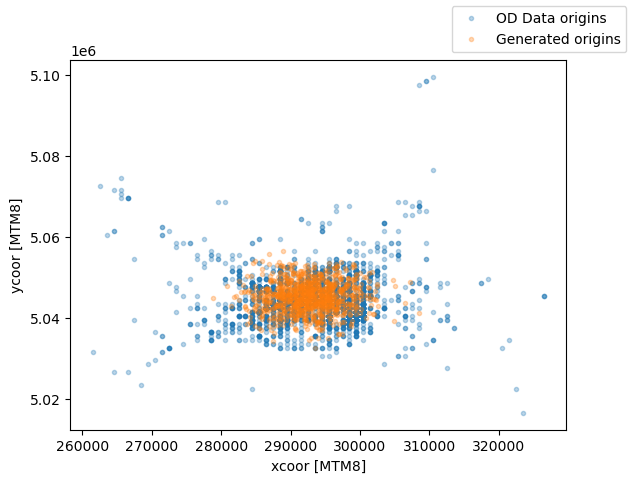

In [44]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.set_xlabel('xcoor [MTM8]')
ax.set_ylabel('ycoor [MTM8]')
ax.plot(df.D_ORIXCOOR,df.D_ORIYCOOR,'.',alpha = 0.3, label = 'OD Data origins')
ax.plot(df_fake_with_noise.D_ORIXCOOR,df_fake_with_noise.D_ORIYCOOR,'.',alpha = 0.3, label = 'Generated origins')
fig.legend()

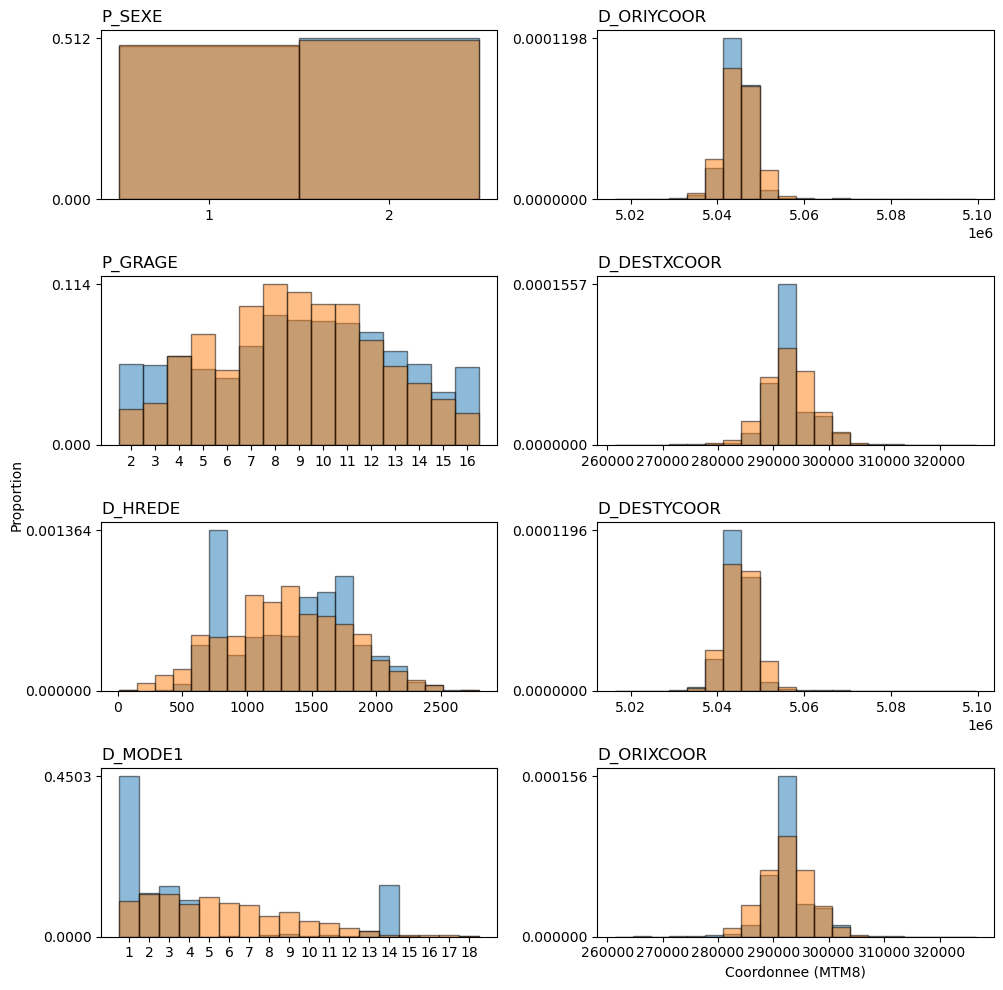

In [28]:
fig, ax = plt.subplots(4,2, figsize = (10,10))

for i in range(len(df.columns)-1):
    unique_values = df[df.columns[i]].nunique()
    col = 0
    if df.columns[i][-4:]=='COOR':
        col = 1
        
    cat = False
    if unique_values < 20:
        bins = np.arange(np.min(df[df.columns[i]])-0.5,np.max(df[df.columns[i]])+1.5,1)
        cat = True
    else:
        bins = 20
    n,bins,_ = ax[i%4][col].hist(df[df.columns[i]], density = True, alpha = 0.5,bins = bins,edgecolor = 'k')
    n2,bins2,_ = ax[i%4][col].hist(fake_df[fake_df.columns[i]],density = True,alpha = 0.5,bins = bins,edgecolor = 'k')
    ax[i%4][col].set_title(df.columns[i],loc = 'left')
    if cat == True:
        ax[i%4][col].set_xticks(bins[:-1]+0.5,(bins[:-1]+0.5).astype(int))

    ax[i%4][col].set_yticks([0,np.max([n,n2])])
#fig.legend(['Enquete OD','Artificiel'], loc = 'upper center')

fig.text(0.0, 0.5, 'Proportion', va='center', rotation='vertical')
ax[-1,1].set_xlabel('Coordonnee (MTM8)')
fig.tight_layout()
fig.savefig('Figures/DA_dists_variables.png',dpi = 200)

Sélection d'un sous-ensemble basé sur des conditions

In [113]:
subset = df_fake_with_noise[(df_fake_with_noise['P_GRAGE']==3) & (df_fake_with_noise['P_SEXE']==2)].sample(4)

In [116]:
df.sample(5)

,P_SEXE,P_GRAGE,D_HREDE,D_ORIXCOOR,D_ORIYCOOR,D_DESTXCOOR,D_DESTYCOOR,D_MODE1,use
7103,2,12,1800,290500,5043500,291500,5046500,1,1
1984,2,10,700,289500,5043500,291500,5040500,1,1
1597,1,6,1115,292500,5046500,302500,5050500,4,1
9761,1,13,800,291500,5044500,288500,5051500,1,1
8996,2,4,1600,292500,5047500,293500,5047500,14,1


In [117]:
df_fake_with_noise.sample(5)

,P_SEXE,P_GRAGE,D_HREDE,D_ORIXCOOR,D_ORIYCOOR,D_DESTXCOOR,D_DESTYCOOR,D_MODE1,use
225,1.0,7.0,1998.0,290854.0,5050293.0,288391.0,5047828.0,9.0,1
920,2.0,11.0,1540.0,296555.0,5052796.0,290703.0,5044203.0,10.0,1
274,2.0,2.0,906.0,299230.0,5046832.0,285877.0,5044593.0,4.0,1
161,1.0,3.0,706.0,290582.0,5045998.0,286750.0,5044386.0,3.0,1
124,1.0,7.0,1314.0,294321.0,5044012.0,297246.0,5043004.0,4.0,1


In [24]:
fake_df

,P_SEXE,P_GRAGE,D_HREDE,D_ORIXCOOR,D_ORIYCOOR,D_DESTXCOOR,D_DESTYCOOR,D_MODE1,use
0,1.0,8.0,1112.0,291529.0,5047256.0,288136.0,5041258.0,8.0,1
1,1.0,8.0,1950.0,293934.0,5043019.0,296079.0,5045649.0,3.0,1
2,1.0,9.0,1268.0,285281.0,5043876.0,287662.0,5047465.0,2.0,1
3,1.0,9.0,542.0,295877.0,5048973.0,293538.0,5048601.0,6.0,1
5,1.0,10.0,1412.0,289347.0,5043772.0,297443.0,5043027.0,4.0,1
...,...,...,...,...,...,...,...,...,...
993,2.0,14.0,1997.0,297920.0,5039742.0,297238.0,5042054.0,4.0,1
994,2.0,2.0,709.0,296620.0,5037741.0,291987.0,5043911.0,6.0,1
995,1.0,4.0,1882.0,294968.0,5043840.0,292533.0,5044770.0,11.0,1
998,1.0,7.0,2008.0,302465.0,5049960.0,301098.0,5042388.0,3.0,1


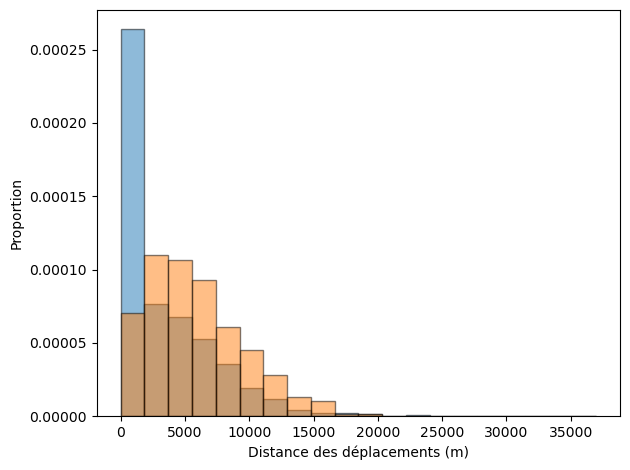

In [26]:
def compute_distances(df):
    dists = ((df.D_DESTXCOOR-df.D_ORIXCOOR)**2-(df.D_DESTYCOOR-df.D_ORIYCOOR)**2)**0.5
    return dists

truedists = compute_distances(df)
fakedists = compute_distances(fake_df)

fig, ax = plt.subplots()
n,bins,_ = ax.hist(truedists,bins = 20, alpha = 0.5,edgecolor = 'k',density = True)
ax.hist(fakedists, bins = bins, alpha = 0.5, edgecolor = 'k',density = True)
ax.set_xlabel('Distance des déplacements (m)')
ax.set_ylabel('Proportion')
fig.tight_layout()
fig.savefig('Figures/DA_distances.png',dpi = 200)
